In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Build Data

In [2]:
reachID_list = pd.read_csv('/glade/u/home/dblaskey/RBM/AK_outlets.csv')

# read in the global MERIT Hydro river basin
geodata = gpd.read_file("/glade/work/mizukami/data/MERIT_hydro/v0/raw/MERIT_Hydro_v07_Basins_v01/riv_pfaf_8_MERIT_Hydro_v07_Basins_v01.shp")

In [3]:
river_test = geodata.loc[geodata['COMID'].isin(reachID_list.x.values)]

In [44]:
river_test['Long'] = river_test.geometry.to_crs(epsg=4326).centroid.x
river_test['Lat'] = river_test.geometry.to_crs(epsg=4326).centroid.y

/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project 

In [46]:
river_test.to_csv('/glade/u/home/dblaskey/RBM/Production_Runs/AK_outlets.csv', index = False)

In [45]:
river_test = river_test[['Lat', 'Long', 'COMID', 'Location']]

In [84]:
def set_loc(s):
    if s['Lat'] > 67.1:
        return "North"
    elif (s['Lat'] < 61.75 and s['Long'] > -156):
        return "South"
    else:
        return "Interior"

river_test['Location'] = river_test.apply(set_loc, axis=1)

In [48]:
river_test.groupby(['Location'])['Location'].count()

Location
Interior    69
North       37
South       32
Name: Location, dtype: int64

In [4]:
gdf = gpd.read_file('/glade/u/home/dblaskey/RBM/Production_Runs/Shapefiles/cb_2018_us_state_500k.shp')

In [5]:
ak_map = gdf[gdf['NAME']=="Alaska"]
ak_map

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
27,02,01785533,0400000US02,02,AK,Alaska,00,1478839695958,245481577452,"MULTIPOLYGON (((179.48246 51.98283, 179.48656 ..."


(-170.0, -140.0)

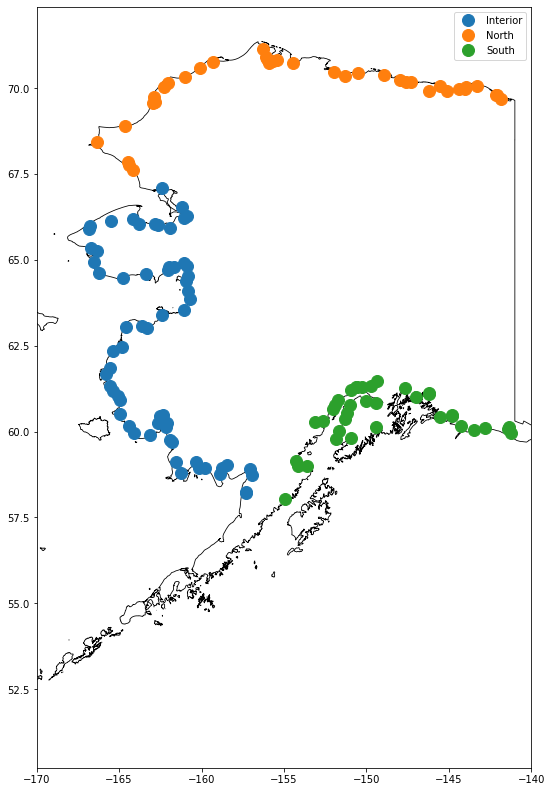

In [9]:
color_values = iter(['blue', 'orange', 'green'])

fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box from the main map
ak_map.plot(linewidth=0.8, ax=ax, facecolor="none", 
              edgecolor='black')
groups = river_test.groupby('Location')
for name, group in groups:
    ax.plot(group.Long, group.Lat, marker='o', linestyle='', markersize=12, label=name)

plt.legend()
plt.xlim([-170, -140]) 

In [47]:
river_test

,Lat,Long,COMID,Location
0,70.833034,-155.422682,81000004,North
1,70.837255,-156.015633,81000005,North
2,70.915635,-156.113898,81000011,North
3,71.150743,-156.243935,81000028,North
4,70.441231,-150.483028,81000069,North
...,...,...,...,...
133,58.250652,-157.315566,81036473,Interior
134,58.033862,-154.941147,81036498,South
135,69.816346,-142.164601,82000054,North
136,69.674101,-141.819274,82000070,North


In [11]:
# Create outlines of basins
for comid in river_test.COMID.values:
    shape_file = gpd.read_file('/glade/scratch/dblaskey/RBM/Shapefiles/subbasin_{}.gpkg'.format(comid)) 
    shape_file['group'] = 1
    dissolved = shape_file.dissolve(by='group')
    dissolved.to_file('/glade/u/home/dblaskey/RBM/Production_Runs/Shapefiles/subbasin_{}.gpkg'.format(comid), driver='GPKG')

# Plot Observation Locations

In [3]:
# Create observation points dataframe
river_test = pd.read_csv('/glade/u/home/dblaskey/RBM/Production_Runs/AK_outlets.csv')
RBM_Basins = pd.read_csv('/glade/u/home/dblaskey/RBM/Optimization/Opt_Basins.csv')
RBM_Basins['opt_val'] = RBM_Basins['type']
points = pd.read_csv('/glade/scratch/dblaskey/RBM/calibration_points.csv')

In [9]:
plot_df = pd.merge(RBM_Basins[['site_no', 'opt_val']], points, how="outer")
plot_df['opt_val'] = plot_df['opt_val'].fillna('Val')
plot_df

,site_no,opt_val,station_nm,Lat,Long,COMID,drain_area_va,unitarea,geometry,outlet_comid,obs_no_year.x,obs_no_year.y,type
0,15803000,Opt,MEADE R AT ATKASUK AK,70.495376,-157.395848,81000092,1790.0,111.404842,"POLYGON ((-157.38875 70.51791666666666, -157.3...",81000005,8.0,9.0,Both Discharge and Temperatue
1,15896000,Val,KUPARUK R NR DEADHORSE AK,70.281385,-148.962786,81000403,3340.0,17.736153,"POLYGON ((-148.96375 70.36125, -148.9604166666...",81000402,8.0,9.0,Both Discharge and Temperatue
2,15908000,Opt,SAGAVANIRKTOK R NR PUMP STA 3 AK,69.015833,-148.817778,81002548,1850.0,88.189503,POLYGON ((-148.7429166666667 69.08458333333334...,81000433,8.0,8.0,Both Discharge and Temperatue
3,15519100,Val,TOLOVANA R BL ROSEBUD C NR LIVENGOOD AK,65.464841,-148.631114,81012001,243.0,22.772364,MULTIPOLYGON (((-148.6304166666667 65.51208333...,81020021,8.0,9.0,Both Discharge and Temperatue
4,15580095,Val,NIUKLUK R AB MELSING C AT COUNCIL AK,64.891944,-163.670000,81014331,707.0,6.200221,POLYGON ((-163.6404166666667 64.89625000000001...,81014324,NaN,8.0,Temperature Gage Only
5,15493000,Val,CHENA R NR TWO RIVERS AK,64.901972,-146.361333,81014458,934.0,95.261951,MULTIPOLYGON (((-146.3995833333334 64.94291666...,81020021,8.0,9.0,Both Discharge and Temperatue
6,15515500,Opt,TANANA R AT NENANA AK,64.564944,-149.094000,81015538,25560.0,3.930487,MULTIPOLYGON (((-149.0795833333333 64.58125000...,81020021,8.0,8.0,Both Discharge and Temperatue
7,15484000,Opt,SALCHA R NR SALCHAKET AK,64.471528,-146.928056,81015621,2200.0,38.261048,"MULTIPOLYGON (((-146.99125 64.49791666666667, ...",81020021,8.0,8.0,Both Discharge and Temperatue
8,15200280,Opt,GULKANA R AT SOURDOUGH AK,62.520392,-145.533015,81023679,1760.0,26.970817,POLYGON ((-145.4520833333333 62.53875000000001...,81030789,8.0,9.0,Both Discharge and Temperatue
9,15292700,Val,TALKEETNA R NR TALKEETNA AK,62.346439,-150.019201,81023793,2010.0,47.030757,POLYGON ((-150.0304166666667 62.42958333333334...,81027459,8.0,9.0,Both Discharge and Temperatue


In [10]:
# Create an empty GeoDataFrame
outline_gdf = gpd.GeoDataFrame()

# Iterate through each basin
for comid in river_test.COMID.values:
    shape_file = gpd.read_file('/glade/u/home/dblaskey/RBM/Production_Runs/Shapefiles/subbasin_{}.gpkg'.format(comid))
    
    # Extract the outline (exterior) of the shapefile
    outline = shape_file.exterior[0]
    
    # Append the outline to the GeoDataFrame
    outline_gdf = outline_gdf.append({'geometry': outline}, ignore_index=True)

outline_gdf['COMID'] = river_test['COMID']
outline_gdf['Location'] = river_test['Location']                      

In [11]:
from pyproj import CRS

# Define the desired CRS
target_crs = CRS.from_epsg(4326)

# Set the CRS for outline_gdf.geometry
outline_gdf.geometry.crs = target_crs

# Perform the coordinate transformation
outline_gdf = outline_gdf.to_crs(target_crs)

In [12]:
river_test['geometry'] = outline_gdf['geometry']

colors = {'Discharge Gage Only': '#D55E00', 'Temperature Gage Only': '#F0E442', 'Both Discharge and Temperatue': '#CC79A7'}

plot_df['Colors'] = plot_df['type'].map(colors)

/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


NameError: name 'legend_handles' is not defined

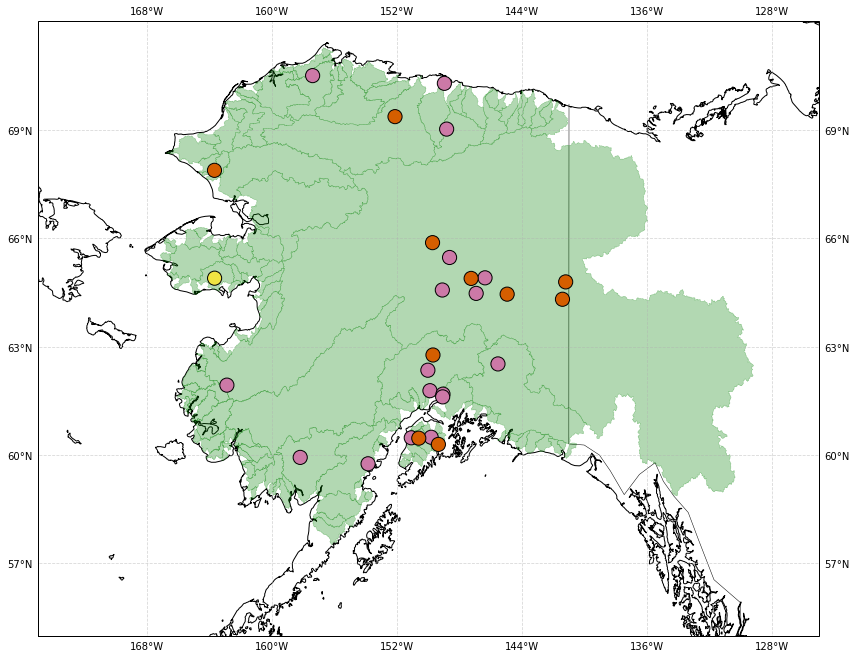

In [13]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Rest of your code...

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Create a GeoDataFrame with a single Polygon representing the entire map extent
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
map_extent = world.unary_union
map_extent_gdf = gpd.GeoDataFrame(geometry=[map_extent], crs=outline_gdf.crs)

# Plot shape files
outline_gdf.geometry.plot(linewidth=0.4, ax=ax, alpha=0.3, facecolor="green", edgecolor='green')

# Set map extent
ax.set_xlim([-175, -125])
ax.set_ylim([55, 72])

# Draw coastlines
ax.coastlines(resolution='10m')

# Add political boundaries
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', alpha=0.5)
gl.xlocator = plt.MaxNLocator(7)
gl.ylocator = plt.MaxNLocator(6)

# Set axis label size and format
ax.tick_params(axis='both', labelsize=14)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Scatter plot
ax.scatter(plot_df.Long, plot_df.Lat, c=plot_df.Colors, s=200, alpha=1.0, edgecolor='black', zorder=10)

# Legend
plt.legend(legend_handles, legend_labels, fontsize=14)
plt.savefig('/glade/u/home/dblaskey/RBM/Production_Runs/Figures/observation_locations.png', dpi=300)
plt.show()

In [14]:
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Convert outline_gdf.Location to pandas.Categorical type
outline_gdf['Location'] = pd.Categorical(outline_gdf.Location)

# Define a colormap for the categories
cmap = plt.cm.get_cmap('Set3', len(outline_gdf.Location.cat.categories))

# Filter plot_df for 'Discharge Gage Only' and 'Both Discharge and Temperature'
plot_df_discharge = plot_df[plot_df.type.isin(['Discharge Gage Only', 'Both Discharge and Temperatue'])]
plot_df_discharge['opt_val'] = 'Val'

# Filter plot_df for 'Temperature Gage Only' and 'Both Discharge and Temperature'
plot_df_temperature = plot_df[plot_df.type.isin(['Temperature Gage Only', 'Both Discharge and Temperatue'])]

/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor r

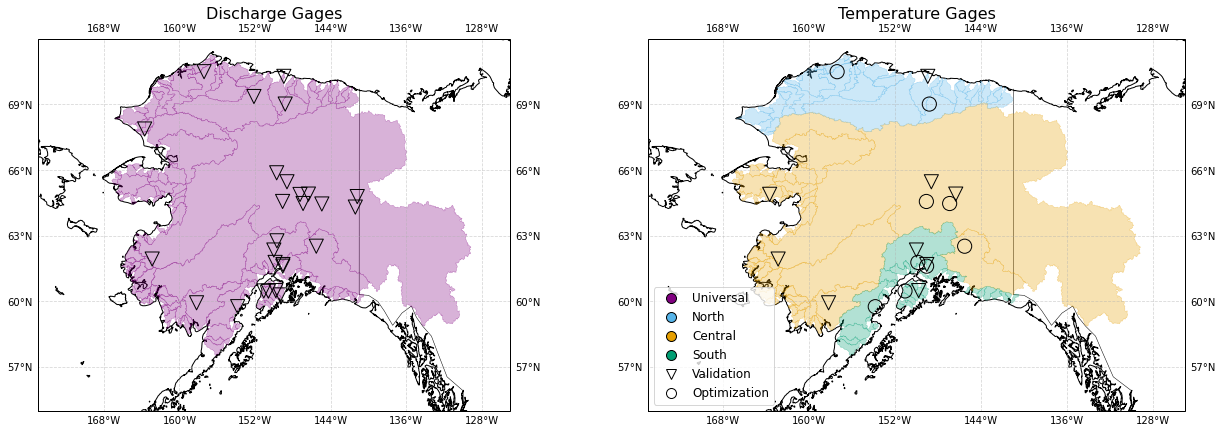

In [17]:
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.lines as mlines

# Convert outline_gdf.Location to pandas.Categorical type
outline_gdf['Location'] = pd.Categorical(outline_gdf.Location)

# Calculate aspect ratio based on desired width and map extent
width = 18  # Desired width of the figure in inches
aspect_ratio = (axes[0].get_xlim()[1] - axes[0].get_xlim()[0]) / (axes[0].get_ylim()[1] - axes[0].get_ylim()[0])
height = width / aspect_ratio

# Create figure and axes for subplots with fixed width and calculated height
fig, axes = plt.subplots(1, 2, figsize=(width, height), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop over the axes and plot the data
for ax, data, title in zip(axes, [plot_df_discharge, plot_df_temperature], ['Discharge Gages', 'Temperature Gages']):
    # Plot shape files
    if title == 'Temperature Gages':
        group_shp = outline_gdf.groupby('Location')
        for name, group in group_shp:
            if name == 'North':
                group.plot(linewidth=0.4, ax=ax, alpha=0.3, facecolor="#56B4E9", edgecolor='#56B4E9')
            elif name == 'Interior':
                group.plot(linewidth=0.4, ax=ax, alpha=0.3, facecolor="#E69F00", edgecolor='#E69F00')
            else:
                group.plot(linewidth=0.4, ax=ax, alpha=0.3, facecolor="#009E73", edgecolor='#009E73')
    else:
        outline_gdf.geometry.plot(linewidth=0.4, ax=ax, alpha=0.3, facecolor='purple', edgecolor='purple')

    # Set map extent
    ax.set_xlim([-175, -125])
    ax.set_ylim([55, 72])

    # Draw coastlines
    ax.coastlines(resolution='10m')

    # Add political boundaries
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', alpha=0.5)
    gl.xlocator = plt.MaxNLocator(7)
    gl.ylocator = plt.MaxNLocator(6)
    
    # Set axis label size and format
    ax.tick_params(axis='both', labelsize=12)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Scatter plot
    scatter_val = ax.scatter(data[data['opt_val'] == 'Val'].Long, data[data['opt_val'] == 'Val'].Lat, c=data[data['opt_val'] == 'Val'].Colors, s=200, alpha=1.0, marker='v', edgecolor='black', zorder=10)
    scatter_opt = ax.scatter(data[data['opt_val'] == 'Opt'].Long, data[data['opt_val'] == 'Opt'].Lat, c=data[data['opt_val'] == 'Opt'].Colors, s=200, alpha=1.0, marker='o', edgecolor='black', zorder=10)
    scatter_val.set_facecolor('none')
    scatter_opt.set_facecolor('none')

    if title == 'Temperature Gages':
        legend_labels = ['Universal', 'North', 'Central', 'South']
        legend_colors = ['purple','#56B4E9', '#E69F00', '#009E73']
        legend_handles_color = [plt.Line2D([], [], marker='o', markersize=10, linestyle='None', markeredgecolor='black', markerfacecolor=color) for color in legend_colors]

        # Create custom legend handles for marker style
        legend_handles_markers = [mlines.Line2D([], [], marker='v', linestyle='None', markersize=10, markeredgecolor='black', markerfacecolor='none', label='Val'),
                                  mlines.Line2D([], [], marker='o', linestyle='None', markersize=10, markeredgecolor='black', markerfacecolor='none', label='Opt')]

        # Combine handles for both legends and labels
        all_handles = legend_handles_color + legend_handles_markers
        all_labels = legend_labels + ['Validation', 'Optimization']

        # Create combined legend
        ax.legend(handles=all_handles, labels=all_labels, loc='lower left', fontsize=12)

    # Set subplot title
    ax.set_title(title, fontsize=16, pad=20)

plt.tight_layout()
plt.savefig('/glade/u/home/dblaskey/RBM/Production_Runs/Figures/observation_locations_panel.png', dpi=300)
plt.show()


<Figure size 432x288 with 0 Axes>

# RBM Results

In [3]:
import xarray as xr
from functools import reduce

def is_summer(month):
    return (month >= 5) & (month <= 9)

rivers = pd.read_csv('/glade/u/home/dblaskey/RBM/Production_Runs/AK_outlets.csv')

In [4]:
list_df = []
for comid in rivers.COMID.values:
    print(comid)
    for year in range(1990,2022):
        ds_rbm = xr.open_mfdataset('/glade/scratch/dblaskey/RBM/Output/Production/%s_%s.nc'%(comid, year))     
        seasonal_data = ds_rbm.sel(time=is_summer(ds_rbm['time.month']))
        seasonal_data = seasonal_data.T_stream.sel(no_seg=2)
        list_df.append([seasonal_data.mean().load().values, 
               seasonal_data.min().load().values, 
               seasonal_data.max().load().values, 
               seasonal_data.var().load().values,
               len(seasonal_data.hru.values), comid, year])

81000004
81000005
81000011
81000028
81000069
81000076
81000102
81000121
81000147
81000200
81000201
81000388
81000402
81000433
81000438
81000440
81000451
81000478
81000486
81000489
81000495
81000496
81000499
81000528
81000668
81001019
81001023
81001134
81001212
81002535
81003294
81005554
81005578
81005819
81007739
81009026
81009065
81010333
81010337
81010407
81010411
81010492
81010509
81010533
81010552
81010563
81013063
81013266
81014324
81014345
81014468
81014496
81014526
81014546
81014700
81014730
81015626
81015634
81015785
81017006
81017157
81018635
81018767
81020021
81020232
81020358
81023726
81023923
81025509
81026165
81027459
81027546
81027607
81027653
81027715
81027912
81027950
81029117
81029183
81029239
81029276
81029391
81029424
81029478
81029506
81029564
81029678
81030776
81030789
81030912
81030920
81030941
81030951
81030973
81031031
81032340
81032397
81032412
81032416
81032472
81032477
81032540
81032575
81032585
81032601
81032612
81032633
81032667
81032872
81032895
81032901
8

In [5]:
df = pd.DataFrame(list_df, columns = ['Mean', 'Min', 'Max', 'Var', 'Length', 'COMID', 'year'])
print((df.Mean*df.Length/df.Length.sum()).sum(), (df.Min*df.Length/df.Length.sum()).sum(), 
      (df.Max*df.Length/df.Length.sum()).sum(), (df.Var*df.Length/df.Length.sum()).sum())

8.300707145359189 0.5027883006168165 16.891328938040818 9.751499318349353


In [9]:
import pymannkendall as mk

In [17]:
test = df[df['COMID'] == 81036460]
mk.original_test(test.Var).slope

-0.0011713686029225048

In [25]:
groups = df.groupby('COMID')
list_df_trend = []
for igroup,group in groups:
    if mk.original_test(test.Mean).p <0.05:
        mean_slope = mk.original_test(test.Mean).slope
    else:
        mean_slope = 0
    if mk.original_test(test.Max).p <0.05:
        max_slope = mk.original_test(test.Max).slope
    else:
        max_slope = 0
    if mk.original_test(test.Min).p <0.05:
        min_slope = mk.original_test(test.Min).slope
    else:
        min_slope = 0
    if mk.original_test(test.Var).p < 0.05:
        var_slope = mk.original_test(test.Var).slope
    else:
        var_slope = 0
        
    list_df_trend.append([mean_slope, max_slope, min_slope, var_slope, igroup])

In [19]:
mean_data = []
max_data = []
min_data = []
var_data = []

for comid in rivers.COMID.values:
    ds_rbm = xr.open_mfdataset('/glade/scratch/dblaskey/RBM/Output/Production/%s_*.nc'%comid)     

    seasonal_data = ds_rbm.sel(time=is_summer(ds_rbm['time.month']))
    seasonal_data = seasonal_data.T_stream.sel(no_seg=2)
    seasonal_data.load()
    
    mean_data.append(seasonal_data.mean(dim='time').to_pandas())
    max_data.append(seasonal_data.max(dim='time').to_pandas())
    min_data.append(seasonal_data.min(dim='time').to_pandas())
    var_data.append(seasonal_data.var(dim='time').to_pandas())

mean_data = pd.concat(mean_data).reset_index()
mean_data.columns = ['COMID', 'mean']
max_data = pd.concat(max_data).reset_index()
max_data.columns = ['COMID', 'max']
min_data = pd.concat(min_data).reset_index()
min_data.columns = ['COMID', 'min']
var_data = pd.concat(var_data).reset_index()
var_data.columns = ['COMID', 'var']

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['COMID'],
                                            how='outer'), [mean_data, max_data, min_data, var_data])

In [20]:
reachID_list = df_merged.COMID.values

# read in the global MERIT Hydro river basin
geodata = gpd.read_file("/glade/work/mizukami/data/MERIT_hydro/v0/raw/MERIT_Hydro_v07_Basins_v01/riv_pfaf_8_MERIT_Hydro_v07_Basins_v01.shp")

river_test = geodata.loc[geodata['COMID'].isin(reachID_list)]
river_test = river_test[river_test.order > 1]
river_test = river_test.merge(df_merged)
river_test.to_file('/glade/u/home/dblaskey/RBM/Production_Runs/Shapefiles/plotall.gpkg', driver='GPKG')

In [ ]:
river_test = gpd.read_file('/glade/u/home/dblaskey/RBM/Production_Runs/Shapefiles/plotall.gpkg')

/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


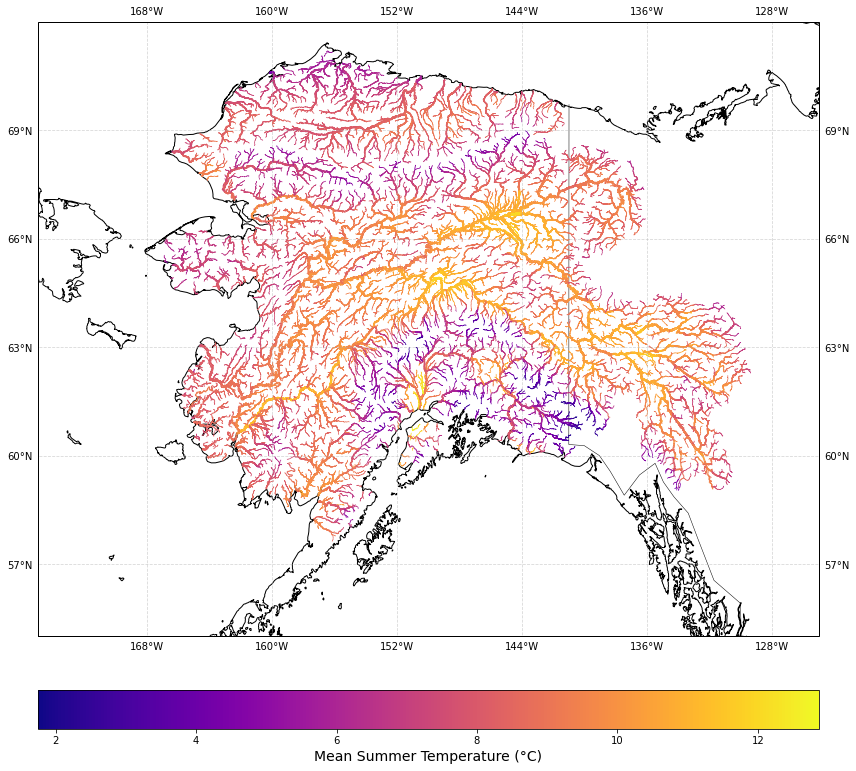

In [61]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Create a GeoDataFrame with a single Polygon representing the entire map extent
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
map_extent = world.unary_union

# Set map extent
ax.set_xlim([-175, -125])
ax.set_ylim([55, 72])

# Draw coastlines
ax.coastlines(resolution='10m')

# Add political boundaries
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', alpha=0.5)
gl.xlocator = plt.MaxNLocator(7)
gl.ylocator = plt.MaxNLocator(6)

# Set axis label size and format
ax.tick_params(axis='both', labelsize=14)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Plot the linestrings using the 'mean' column for color
river_test.plot(ax=ax, column='mean', cmap='plasma', linewidth=river_test['order']/3)

# Add colorbar legend
sm = plt.cm.ScalarMappable(cmap='plasma')
sm.set_array(river_test['mean'])
cbar = plt.colorbar(sm, ax=ax, fraction=0.06, pad=0.07, orientation='horizontal')
cbar.ax.set_xlabel('Mean Summer Temperature (°C)', fontsize=14)

#plt.savefig('/glade/u/home/dblaskey/RBM/Production_Runs/Figures/results_geographic.png', dpi=300)
plt.show()

/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor r

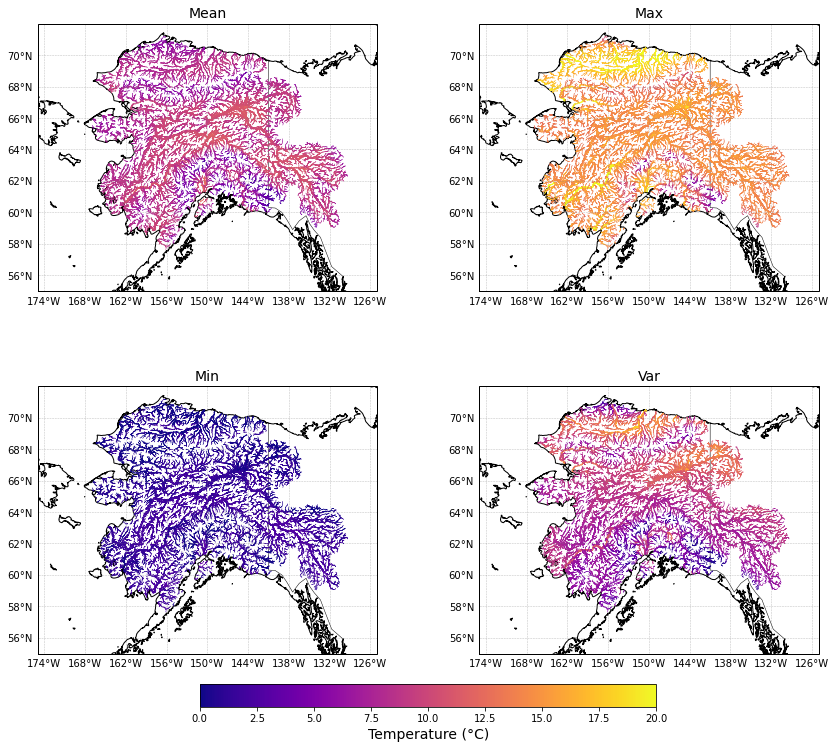

In [22]:
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig, axes = plt.subplots(2, 2, figsize=(14, 14), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.05, wspace=0.3)

# Create a GeoDataFrame with a single Polygon representing the entire map extent
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
map_extent = world.unary_union

# Draw coastlines
for ax in axes.flatten():
    ax.coastlines(resolution='10m')

# Add political boundaries
for ax in axes.flatten():
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')

# Plot the linestrings for each column
columns = ['mean', 'max', 'min', 'var']

# Initialize colorbar properties
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=20))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, fraction=0.03, pad=0.04, orientation='horizontal')
cbar.ax.set_xlabel('Temperature (°C)', fontsize=14)

for i, col in enumerate(columns):
    row = i // 2
    col = i % 2
    
    # Set latitude and longitude limits
    axes[row, col].set_xlim([-175, -125])
    axes[row, col].set_ylim([55, 72])
    
    
    river_test.plot(ax=axes[row, col], column=columns[i], cmap='plasma', linewidth=river_test['order'] / 4, vmin=0, vmax=20)
    axes[row, col].set_title(columns[i].capitalize(), fontsize=14)
    
    # Add gridlines to each subplot
    gl = axes[row, col].gridlines(draw_labels=True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

plt.savefig('/glade/u/home/dblaskey/RBM/Production_Runs/Figures/results_geographic_all.png', dpi=300)
plt.show()